In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import timm  # We'll use official MobileViT from timm for simplicity & reliability
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


In [2]:
import os

# The actual root folder containing Training and Testing
data_dir = "/kaggle/input/brain2-filtered/brain2_filtered"

train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
num_classes = len(classes)

# Verify the structure and count images per class
print("Dataset path:", data_dir)
print("\nTraining set distribution:")
total_train = 0
total_test = 0

for cls in classes:
    train_path = os.path.join(train_dir, cls)
    test_path = os.path.join(test_dir, cls)
    
    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0
    
    print(f"{cls}: Train = {train_count}, Test = {test_count}")
    
    total_train += train_count
    total_test += test_count

print(f"\nTotal Training images: {total_train}")
print(f"Total Testing images: {total_test}")
print(f"Total images: {total_train + total_test}")

# Optional: Show a few example file paths to confirm access
print("\nSample training file paths (first 2 per class):")
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    if os.path.exists(train_path):
        files = sorted(os.listdir(train_path))[:2]  # sorted for consistency
        if files:
            print(f"{cls}:")
            for f in files:
                print(f"   {os.path.join(train_path, f)}")

Dataset path: /kaggle/input/brain2-filtered/brain2_filtered

Training set distribution:
glioma: Train = 1321, Test = 300
meningioma: Train = 1339, Test = 306
notumor: Train = 1595, Test = 405
pituitary: Train = 1457, Test = 300

Total Training images: 5712
Total Testing images: 1311
Total images: 7023

Sample training file paths (first 2 per class):
glioma:
   /kaggle/input/brain2-filtered/brain2_filtered/Training/glioma/Tr-glTr_0000.jpg
   /kaggle/input/brain2-filtered/brain2_filtered/Training/glioma/Tr-glTr_0001.jpg
meningioma:
   /kaggle/input/brain2-filtered/brain2_filtered/Training/meningioma/Tr-meTr_0000.jpg
   /kaggle/input/brain2-filtered/brain2_filtered/Training/meningioma/Tr-meTr_0001.jpg
notumor:
   /kaggle/input/brain2-filtered/brain2_filtered/Training/notumor/Tr-noTr_0000.jpg
   /kaggle/input/brain2-filtered/brain2_filtered/Training/notumor/Tr-noTr_0001.jpg
pituitary:
   /kaggle/input/brain2-filtered/brain2_filtered/Training/pituitary/Tr-piTr_0000.jpg
   /kaggle/input/brai

In [3]:
# Strong augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Only resize + normalize for testing
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 5712
Testing samples: 1311


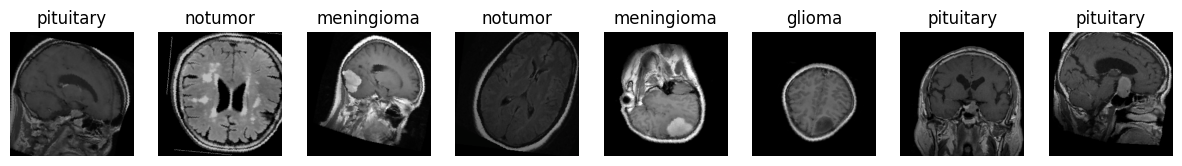

In [4]:
def show_augmented_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    for i in range(num_images):
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_augmented_images(train_dataset)

In [5]:
# Use official MobileViT from timm (lightweight & efficient)
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=num_classes)

# Modify if you want smaller variants: 'mobilevit_xxs', 'mobilevit_xs', 'mobilevit_s'
model = model.to(device)

print(model.default_cfg)  # Shows input size, etc.
print(f"Model loaded with {num_classes} output classes.")

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

{'url': '', 'hf_hub_id': 'timm/mobilevit_s.cvnets_in1k', 'architecture': 'mobilevit_s', 'tag': 'cvnets_in1k', 'custom_load': False, 'input_size': (3, 256, 256), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.0, 0.0, 0.0), 'std': (1.0, 1.0, 1.0), 'num_classes': 1000, 'pool_size': (8, 8), 'first_conv': 'stem.conv', 'classifier': 'head.fc'}
Model loaded with 4 output classes.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

num_epochs = 25
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

In [7]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * val_correct / val_total
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_mobilevit_brain_tumor.pth")
        print("  → New best model saved!")
    
    scheduler.step(val_acc)

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")


Epoch 1/25


100%|██████████| 179/179 [01:00<00:00,  2.96it/s]


Train Loss: 0.6734 | Train Acc: 83.07% | Val Acc: 88.25%
  → New best model saved!

Epoch 2/25


100%|██████████| 179/179 [01:03<00:00,  2.81it/s]


Train Loss: 0.2369 | Train Acc: 92.56% | Val Acc: 94.28%
  → New best model saved!

Epoch 3/25


100%|██████████| 179/179 [01:03<00:00,  2.81it/s]


Train Loss: 0.1709 | Train Acc: 94.80% | Val Acc: 93.14%

Epoch 4/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.1251 | Train Acc: 96.22% | Val Acc: 95.19%
  → New best model saved!

Epoch 5/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.1046 | Train Acc: 96.76% | Val Acc: 97.03%
  → New best model saved!

Epoch 6/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0879 | Train Acc: 97.32% | Val Acc: 96.57%

Epoch 7/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0812 | Train Acc: 97.23% | Val Acc: 98.32%
  → New best model saved!

Epoch 8/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0617 | Train Acc: 98.30% | Val Acc: 97.56%

Epoch 9/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0499 | Train Acc: 98.37% | Val Acc: 98.47%
  → New best model saved!

Epoch 10/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0553 | Train Acc: 98.09% | Val Acc: 98.09%

Epoch 11/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0424 | Train Acc: 98.51% | Val Acc: 98.93%
  → New best model saved!

Epoch 12/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0388 | Train Acc: 98.93% | Val Acc: 98.47%

Epoch 13/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0449 | Train Acc: 98.56% | Val Acc: 98.40%

Epoch 14/25


100%|██████████| 179/179 [01:04<00:00,  2.78it/s]


Train Loss: 0.0350 | Train Acc: 98.93% | Val Acc: 98.70%

Epoch 15/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0309 | Train Acc: 99.05% | Val Acc: 99.01%
  → New best model saved!

Epoch 16/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0243 | Train Acc: 99.33% | Val Acc: 98.93%

Epoch 17/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0305 | Train Acc: 98.91% | Val Acc: 97.71%

Epoch 18/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0216 | Train Acc: 99.35% | Val Acc: 98.93%

Epoch 19/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0161 | Train Acc: 99.53% | Val Acc: 98.93%

Epoch 20/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0167 | Train Acc: 99.46% | Val Acc: 99.47%
  → New best model saved!

Epoch 21/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0088 | Train Acc: 99.74% | Val Acc: 99.24%

Epoch 22/25


100%|██████████| 179/179 [01:04<00:00,  2.80it/s]


Train Loss: 0.0112 | Train Acc: 99.68% | Val Acc: 99.62%
  → New best model saved!

Epoch 23/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0113 | Train Acc: 99.63% | Val Acc: 99.39%

Epoch 24/25


100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


Train Loss: 0.0135 | Train Acc: 99.56% | Val Acc: 99.69%
  → New best model saved!

Epoch 25/25


100%|██████████| 179/179 [01:04<00:00,  2.78it/s]


Train Loss: 0.0111 | Train Acc: 99.70% | Val Acc: 99.62%

Training complete! Best validation accuracy: 99.69%


In [8]:
torch.save(model.state_dict(), "/kaggle/working/final_mobilevit_brain_tumor.pth")
print("Final model automatically saved!")

Final model automatically saved!


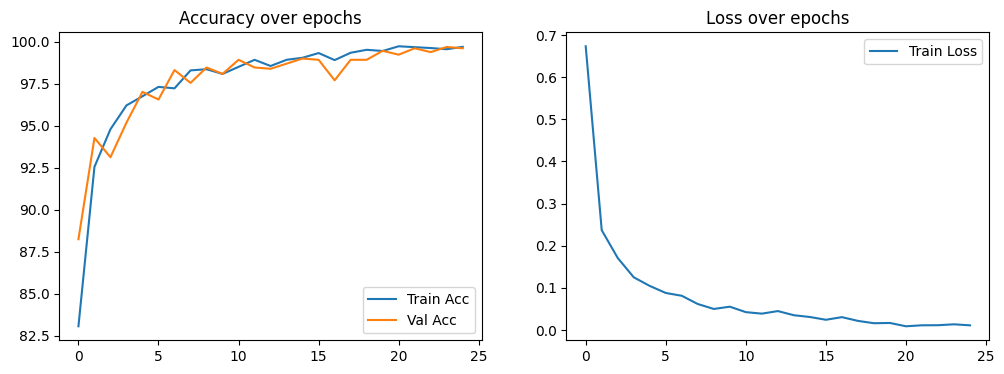

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



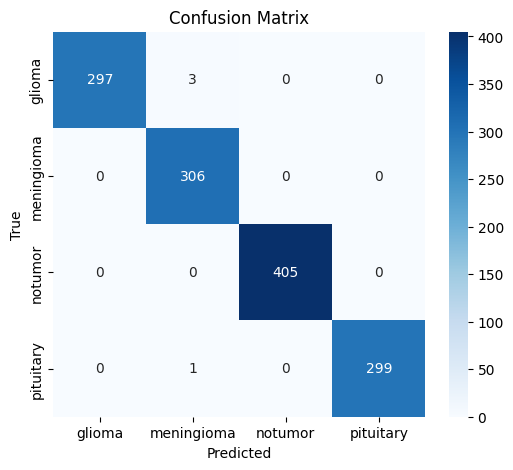

In [10]:
# Load best model
model.load_state_dict(torch.load("best_mobilevit_brain_tumor.pth"))
model.eval()

# Full evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()